# Generative ML

In [1]:
%load_ext autoreload
%autoreload 2

**Caution**: we are using keras merely to get hold of a standardized version of the popular dataset MNIST. keras is a deep learning library (a wrapper for TensorFlow) but there would be no need for deep learning methods in this demo. Do not worry if you get deprecation warnings when you load the keras module. These are due to some incompatibilities between keras and numpy that would hopefully be resolved by their respective teams soon.

In [2]:
import numpy as np
from numpy import random as rand
from numpy import linalg as lin
import random
from keras.datasets import mnist
from matplotlib import pyplot as plt

**Caution**: when executing the load_data() method below for the first time, keras will attempt to download this dataset from an internet source. Make sure you have a working internet connection at that point. Once downloaded, the dataset would be cached on your machine and subsequent executions would not require fresh downloads from the internet

In [3]:
def getFigList( nrows = 1, ncols = 1, sizex = 3, sizey = 3 ):
    fig, axs = plt.subplots( nrows = nrows, ncols = ncols, figsize = (sizex * ncols, sizey * nrows), squeeze = 0 )
    axs = axs.reshape( -1 )
    return (fig, axs)

def showImagesNoAxes( axes, imageList, numRows, numCols, resize = False, imShape = [], cmap = plt.cm.gray_r, labelList = [] ):
    for i in range( numRows * numCols ):
        currAxis = axes[i]
        im = imageList[i]
        if resize:
            # Reshaping an indexed element of an array does not modify the original data so we are safe 
            im = im.reshape( imShape )
        currAxis.imshow( im, cmap = cmap, interpolation = 'nearest' )
        currAxis.tick_params( axis = 'x', which = "both", bottom = False, labelbottom = False )
        currAxis.tick_params( axis = 'y', which = "both", left = False, labelleft = False )
        if labelList:
            currAxis.set_title( labelList[i] )

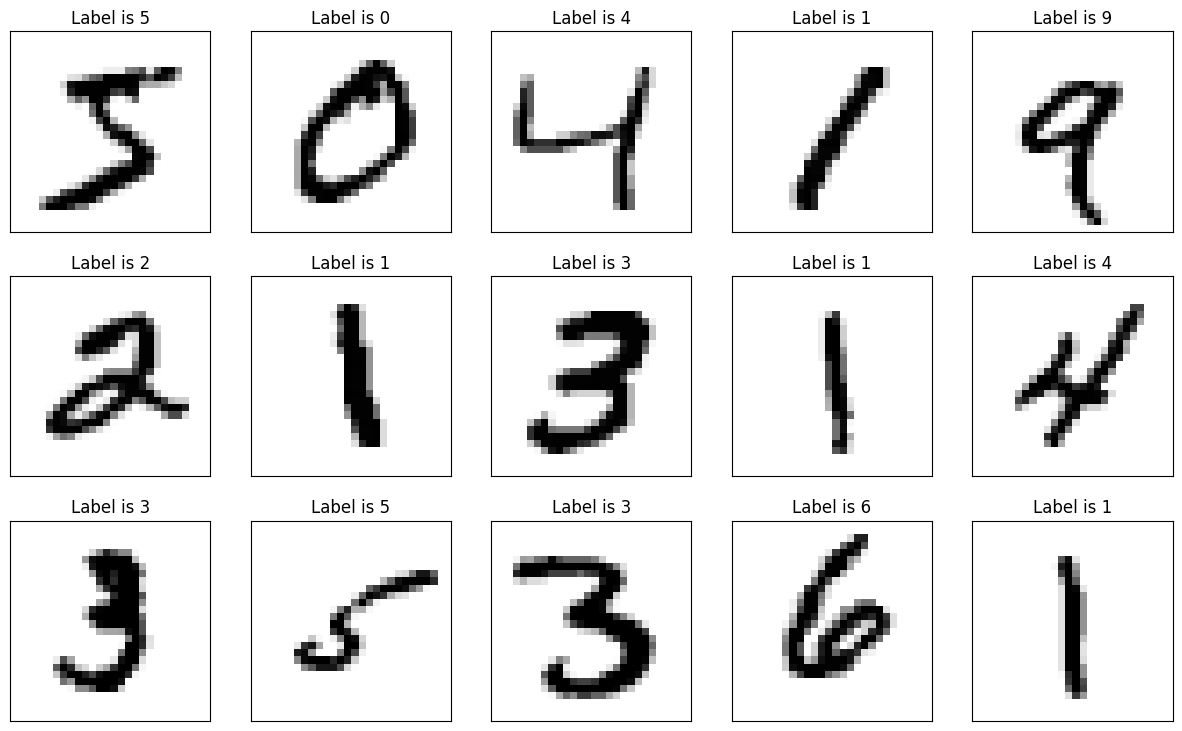

In [4]:
((XTrain, yTrain), (XTest, yTest)) = mnist.load_data()

# How many training images do we have?
n = XTrain.shape[0]

# What is the shape of these images?
imShape = XTrain.shape[1:]

# Normalize data coordinates otherwise numbers in later calculations might explode
XTrain = XTrain/256

numRows = 3
numCols = 5

# Show the first 15 images in the dataset
fig, axs = getFigList( numRows, numCols )
labels = [ "Label is %s" % yTrain[i] for i in range( numRows * numCols ) ]
showImagesNoAxes( axs, XTrain[ :numRows*numCols ], numRows, numCols, labelList = labels )

**Creating a subdataset**: to make the generative learning problem simpler, let us create a smaller version of this dataset with just the images of digits 1 and 4 in the training set.

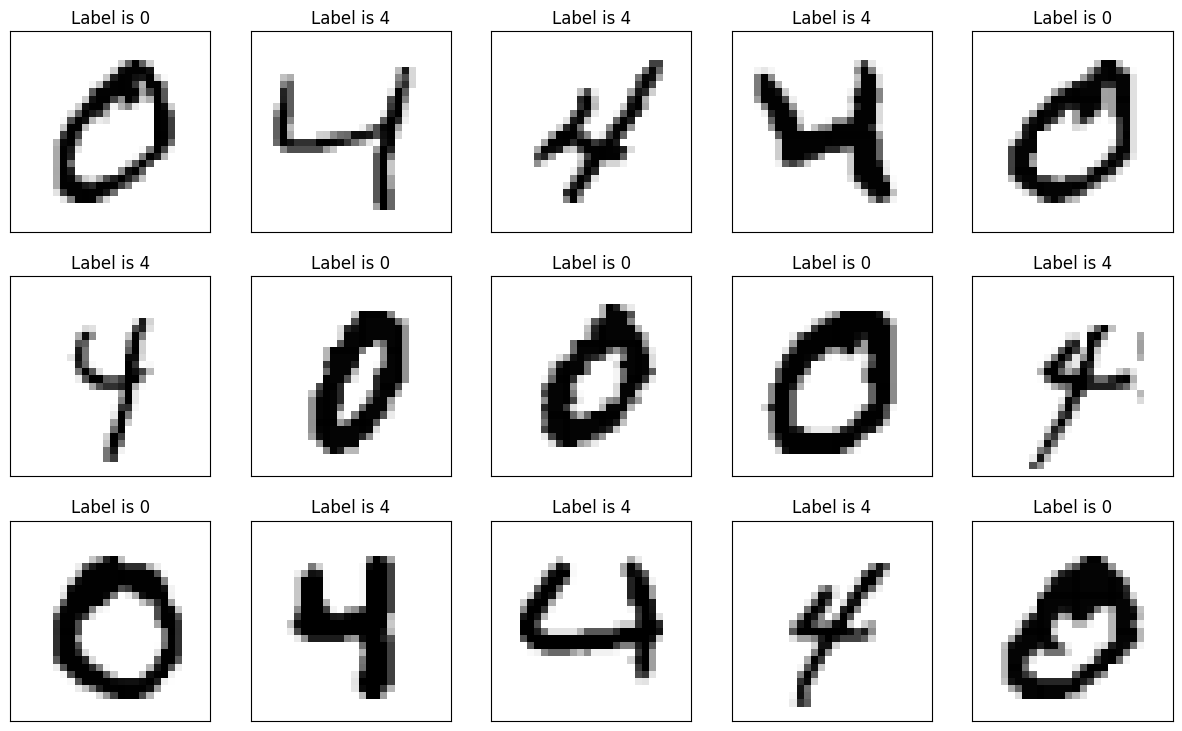

In [5]:
def getDataSubset( labels ):
    subset = np.in1d( yTrain, labels )
    return (XTrain[subset][:][:], yTrain[subset])

labels = np.array( [0,4] )
(X,y) = getDataSubset( labels )

# Flatten images for sake of convenience even though it is time consuming and not essential at all
n = X.shape[0]
d = np.prod( X.shape[1:] )
X = X.reshape( n, d )

# Display the first few images of this subset dataset
fig2, axs2 = getFigList( numRows, numCols )
labels = [ "Label is %s" % y[i] for i in range( numRows * numCols ) ]
showImagesNoAxes( axs2, X[ :numRows*numCols ], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**Getting started**: let us start by fitting a single standard Gaussian as a generative model to our toy dataset of 0 and 4 images. We will see that this does not produce very good results at all. The mean image seems to be a ghostly superimposition of a 0 and a 4 which makes sense given the dataset contains 0s and 4s. The covariance structure is not getting learnt here at all (we are using the identity matrix as covaraiance) and the images generated out of this generative model turn out to be less than useful. Learning the structure of the covariance (and higher moments as well if possible) is vital in generative models.

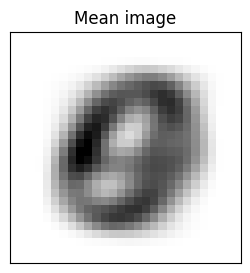

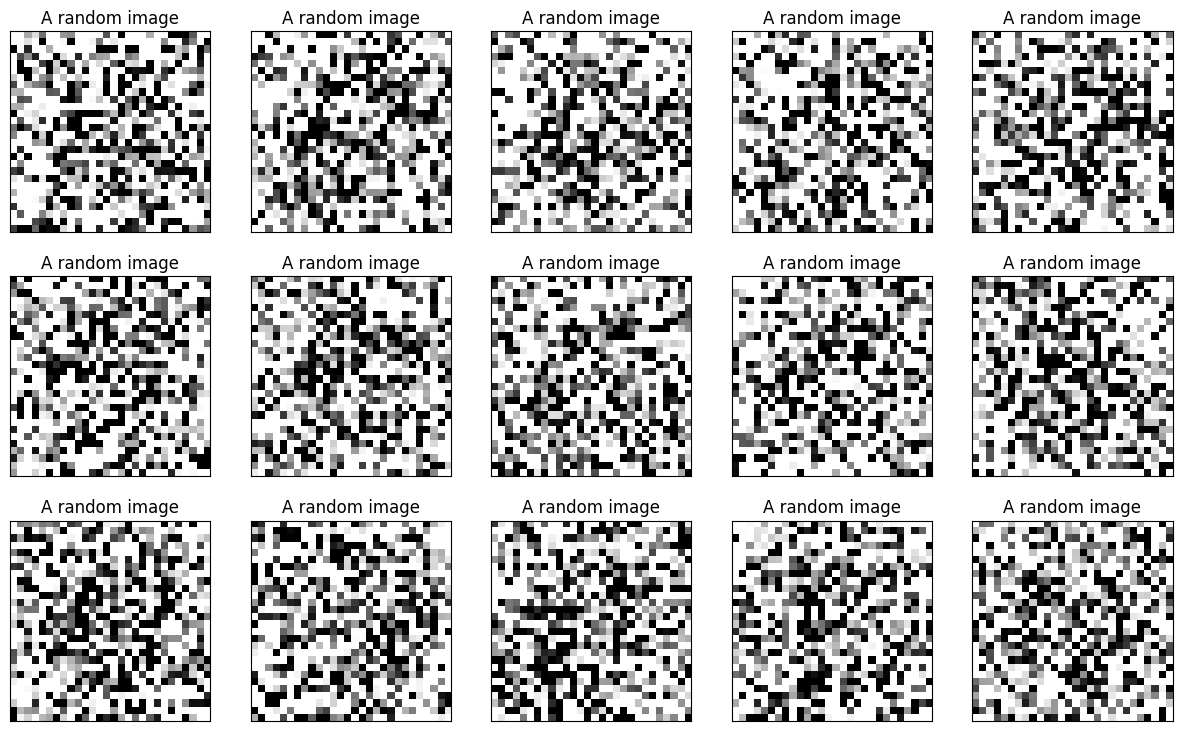

In [6]:
def fitSingleStandardGaussian( X ):
    return np.mean( X, axis = 0 )

def truncatePixels( X, low = 0, high = 1 ):
    X[X < low] = low
    X[X > high] = high
    return X

# Fit a standard Gaussian to the 0,4 dataset using an MLE
mu = fitSingleStandardGaussian( X )
fig3, axs3 = getFigList( 1, 1 )
labels = [ "Mean image" ]
showImagesNoAxes( axs3, mu[ np.newaxis, : ], 1, 1, resize = True, imShape = imShape, labelList = labels )

# Display a few samples taken from this distribution -- we will find these to be extremely noisy
fig4, axs4 = getFigList( numRows, numCols )
labels = [ "A random image" for i in range( numRows * numCols ) ]
randSamples = rand.multivariate_normal( mu, np.identity(d), size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels(randSamples)
showImagesNoAxes( axs4, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**The limits of a single Gaussian**: Let us learn a proper Gaussian now with both the mean and covariance getting learnt. The mean is the same as before but the crucial difference is that the covariance is getting learnt now. Notice the significant improvement in the quality of the images generated from this generative model. Although still far from satisfactory, the images at least show some semblance of 0 and 4 shapes haphazardly placed on top of each other. Learning the covariance structure properly itself caused this huge improvement.

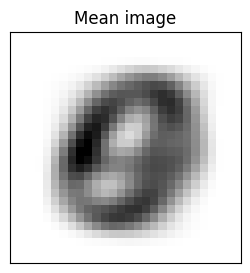

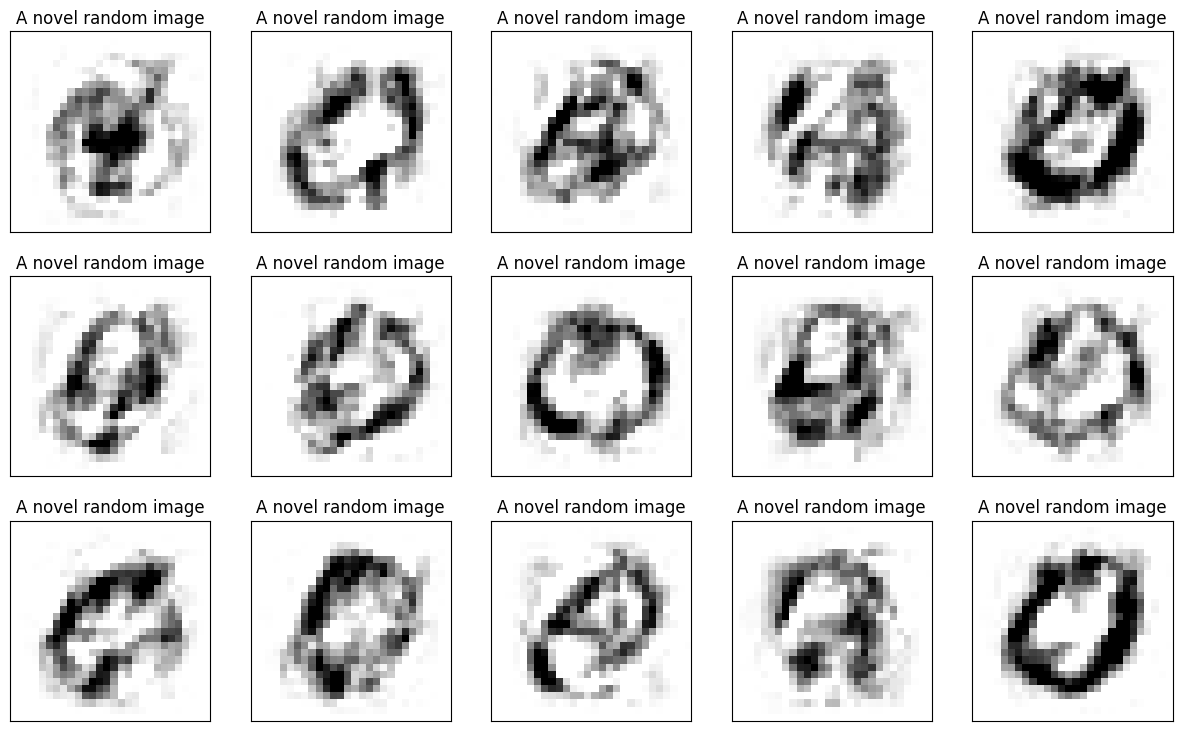

In [7]:
def fitSingleGaussian( X ):
    n = X.shape[0]
    d = np.prod( X.shape[1:] )
    X = X.reshape( n, d )
    mu = np.mean( X, axis = 0 )
    Xcent = X - mu
    cov = 1/n*(Xcent.T).dot(Xcent)
    return (mu, cov)

# Fit a general Gaussian this time to the same dataset
(mu, cov) = fitSingleGaussian( X )

fig5, axs5 = getFigList( 1, 1 )
labels = [ "Mean image" ]
showImagesNoAxes( axs5, mu[ np.newaxis, : ], 1, 1, resize = True, imShape = imShape, labelList = labels )

# The quality of samples is a bit better due to use of a general covariance matrix but not much better
fig6, axs6 = getFigList( numRows, numCols )
labels = [ "A novel random image" for i in range( numRows * numCols ) ]
randSamples = rand.multivariate_normal( mu, cov, size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels( randSamples )
showImagesNoAxes( axs6, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**A mixture of Gaussians**: since we know that our toy dataset contains a bunch of 0s and 4s whose appearances differ significantly, it is not surprising that a single Gaussian was unable to capture the diversity in the dataset. Let us now fit a mixture of Gaussians to this dataset. We need at least 2 components in this mixture (i.e. at least 2 Gaussians) but it is better to use slightly more e.g. 4 or more since even within a digit, there may be variations in writing style e.g. the digit 4 written upright vs written slanted.

Note that we are assuming that we do not have the labels of the imags in our training set i.e. we do not know which images are labeled 0 and which are labeled 4. This means that we would have to model this as a latent variable and use the EM algorithm to fit the mixture of Gaussians. Even if we had known the labels of the images, we would have still required the EM algorithm if, for example, we want to model the 4s using 3 components to account for variations of style etc. Since the images surely do not come labeled whether they are upright or slanted, a latent variable will be required to model this information.

**Number of Components**: Notice the significantly better samples generated by this mixture model. The samples are very realistic, diverse, yet are novel, i.e. these were never seen in training set. The quality of the samples would generally go up as the number of mixture components goes up, but if the number of components gets very large, then the method would start suffering since not only would it become slow, the number of data points per component would also fall and each component would get estimated not very well. The number of components in the mixture is a hyperparameter that needs to be tuned carefully. Too small and diversity would not be captured, too large and estimation and speed would suffer.

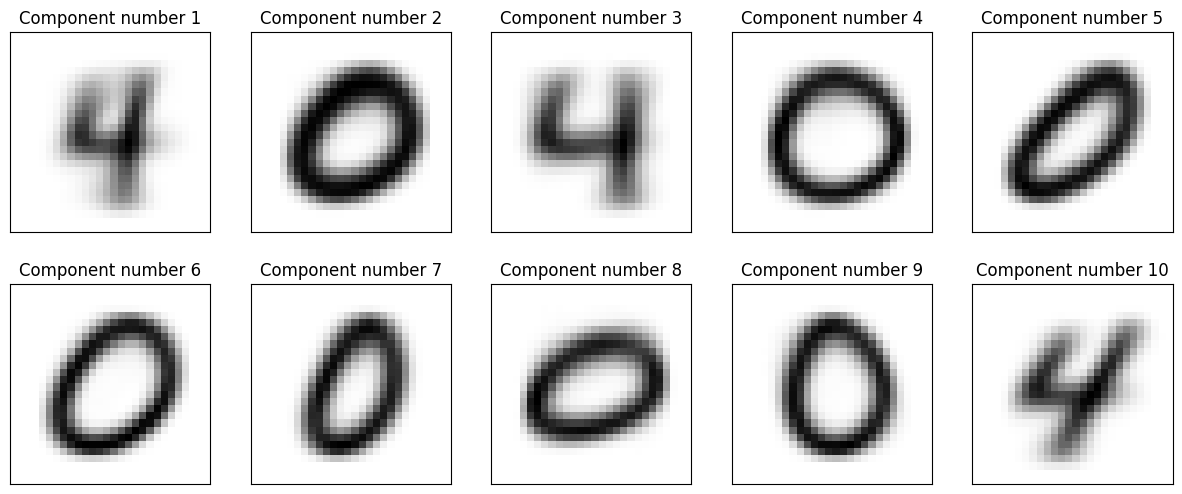

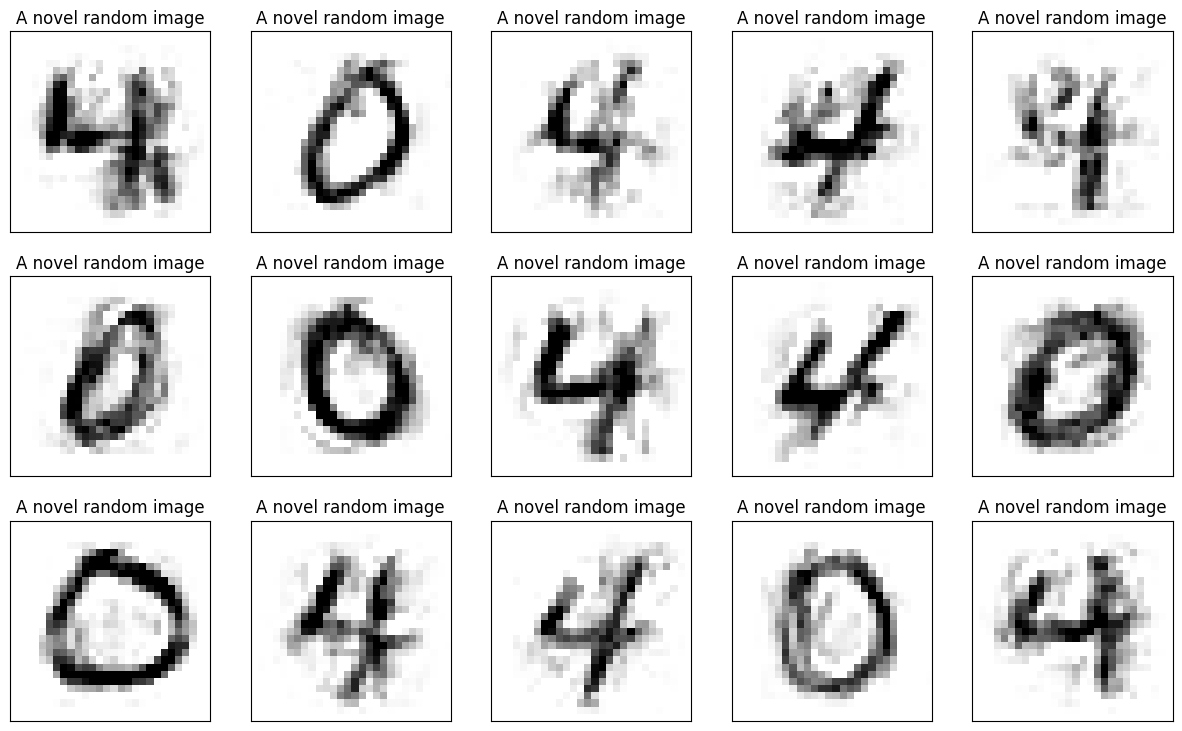

In [8]:
# A fast way to compute all pairs distances using Python's broadcasting techniques
def getAllPairsDistances( A, B ):
    squaredNormsA = np.square( lin.norm( A, axis = 1 ) )
    squaredNormsB = np.square( lin.norm( B, axis = 1 ) )
    return squaredNormsA[:, np.newaxis] + squaredNormsB - 2 * A.dot( B.T )

# Perform the k-means++ initialization
def doKMPPInitGreedy( X, C ):
    init = np.zeros( (C, X.shape[1]) )
    n = X.shape[0]
    # Choose a random data point and make it a centroid
    i = random.randint( 0, n-1 )
    init[0,:] = X[i,:]
    for t in range( 1, C ):
        # For all data points, find the squared Euclidean distance to the closest centroid
        # Python is funny: init[0,:] generates a vector but init[0:1,:] generates a matrix with one row :)
        dist = np.min( getAllPairsDistances( X, init[0:t,:] ), axis = 1 )
        i = np.argmax( dist )
        init[t,:] = X[i,:]
    return init

def getSigmaInit( C, d ):
    iden = np.identity( d )
    init = np.zeros( (C, d, d) )
    for i in range( C ):
        init[i] = iden
    return init

# Obtain probability of data point x^i belonging to component N(\mu^c, S^c)
# The proper way of computing this is 1/\sqrt((2\pi)^d*|S^c|)*exp( - (x^i - \mu^c)'(S^c)^{-1}(x^i - \mu^c))
# However, this can be very expensive due to all the inverses involved
# Cheaper shortcut: approximate S^c by the identity matrix I_d
def doEStep( X, muVals, SigmaVals ):
    qVals = np.exp( -getAllPairsDistances( X, muVals ) / 2 )        
    rowSum = qVals.sum( axis = 1 )
    qVals = qVals / rowSum[:, np.newaxis]
    return qVals

# Ute the models by optimizing the Q function given by the E Step
# Ideally, both means and covariances for all components should be uted
# The solution to the weighted MLE for the covariance matrix ute can be shown to be
# S^c = 1/Q_c * \sum_{i=1}^n q^i_c (x^i - \mu^c)(x^i - \mu^c)^T where Q_c = \sum_{i=1}^n q^i_c
# Cheaper shortcut: do not ute covariance matrix at every M step (ute only means every time)
# Ute covariance only at the end (we are anyway not using SigmaVals to compute the E step)
def doMStep( X, qVals, C, prevMuVals, prevSigmaVals ):
    d = X.shape[1]
    muVals = np.zeros( (C, d) )
    SigmaVals = np.zeros( (C, d, d) )
    
    # Process every component
    for c in range( C ):
        # Get hold of the weights different data points have given to this component
        q = qVals[:, c]
        amountData = sum(q)
        # If there is enough data for this component, do weighted MLE estimation
        if amountData > 1:
            muVals[c] = (X.T).dot( q )/amountData
        # If some cluster is almost empty, return the old value of its centroid
        else:
            muVals[c] = prevMuVals[c]
    return (muVals, SigmaVals)

# Execute the EM algorithm for jointly learning a mixture of general (not standard) Gaussians
def doEMGMM( X, C, initMu, initSigma, niter ):
    muVals = initMu
    SigmaVals = initSigma
    # Perform the EM algorithm for niter steps
    for t in range( niter ):
        qVals = doEStep( X, muVals, SigmaVals )
        (muVals, SigmaVals) = doMStep( X, qVals, C, muVals, SigmaVals )
    # Cheaper shortcut we employed -- doing costly S^c utes only once at the end
    for c in range( C ):
        q = qVals[:, c]
        amountData = sum(q)
        if amountData > 1:
            Xcent = X - muVals[c]
            wXCent = (Xcent.T * q).T
            SigmaVals[c] = 1 / amountData * (wXCent.T).dot( Xcent )
    return (muVals, SigmaVals, qVals)

# Number of components in the Gaussian mixture model (GMM)
C = 10
niter = 5

initMu = doKMPPInitGreedy( X, C )
initSigma = getSigmaInit( C, X.shape[1] )
(muVals, SigmaVals, qVals) = doEMGMM( X, C, initMu, initSigma, niter )
        
numRows = 2
numCols = C//2

# Visualize the means/modes of the various components the EM algorithm returned
# Notice how the various components do not just capture the different digits but also
# different ways/styles of writing each digit e.g. slanted 0 vs fat round 0 etc
fig7, axs7 = getFigList( numRows, numCols )
labels = [ "Component number %s" % (i+1) for i in range( numRows * numCols ) ]
showImagesNoAxes( axs7, muVals, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

numRows = 3
numCols = 5

fig8, axs8 = getFigList( numRows, numCols )
labels = [ "A novel random image" for i in range( numRows * numCols ) ]
randSamples = np.zeros( (numRows * numCols, d) )
for i in range( numRows * numCols ):
    # Choose a random component of the GMM from which to sample
    # It should be noted here that we have not used the label information in the data at all
    # All these results are being achieved in a completely "unsupervised" setting
    # Also note that all of these are novel images -- that never appeared in the training set
    # Notice the significantly improved quality of the novel images compared to previous attempts
    idx = random.randint( 0, C - 1 )
    randSamples[i] = rand.multivariate_normal( muVals[idx], SigmaVals[idx], check_valid = "raise" )

randSamples = truncatePixels( randSamples )
showImagesNoAxes( axs8, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**Classification using a Generative Model**: Generative models can not only generate new examples, they can also be used to classify data points as well. In the following, we take the full MNIST dataset (i.e. not just 0s or 4s or 7s) and learn a single Gaussian per class. Note that now we are indeed using the labels of the images i.e. we are no longer doing EM. We are simply learning the mean and covariance for 10 Gaussians, one corresponding to each of the classes {0, 1, ..., 9} in the dataset. This method gets an 85.73% prediction accuracy on the test dataset. This is decent although not very impressive. Using kernel SVMs, it is possible to get around 95% prediction accuracy and deep convolutional networks can drive this up to 99.9% and above. However, notice that this is an extremely simple generative model and yet it offers some decent prediction accuracy.

Prediction Accuracy:  0.8573


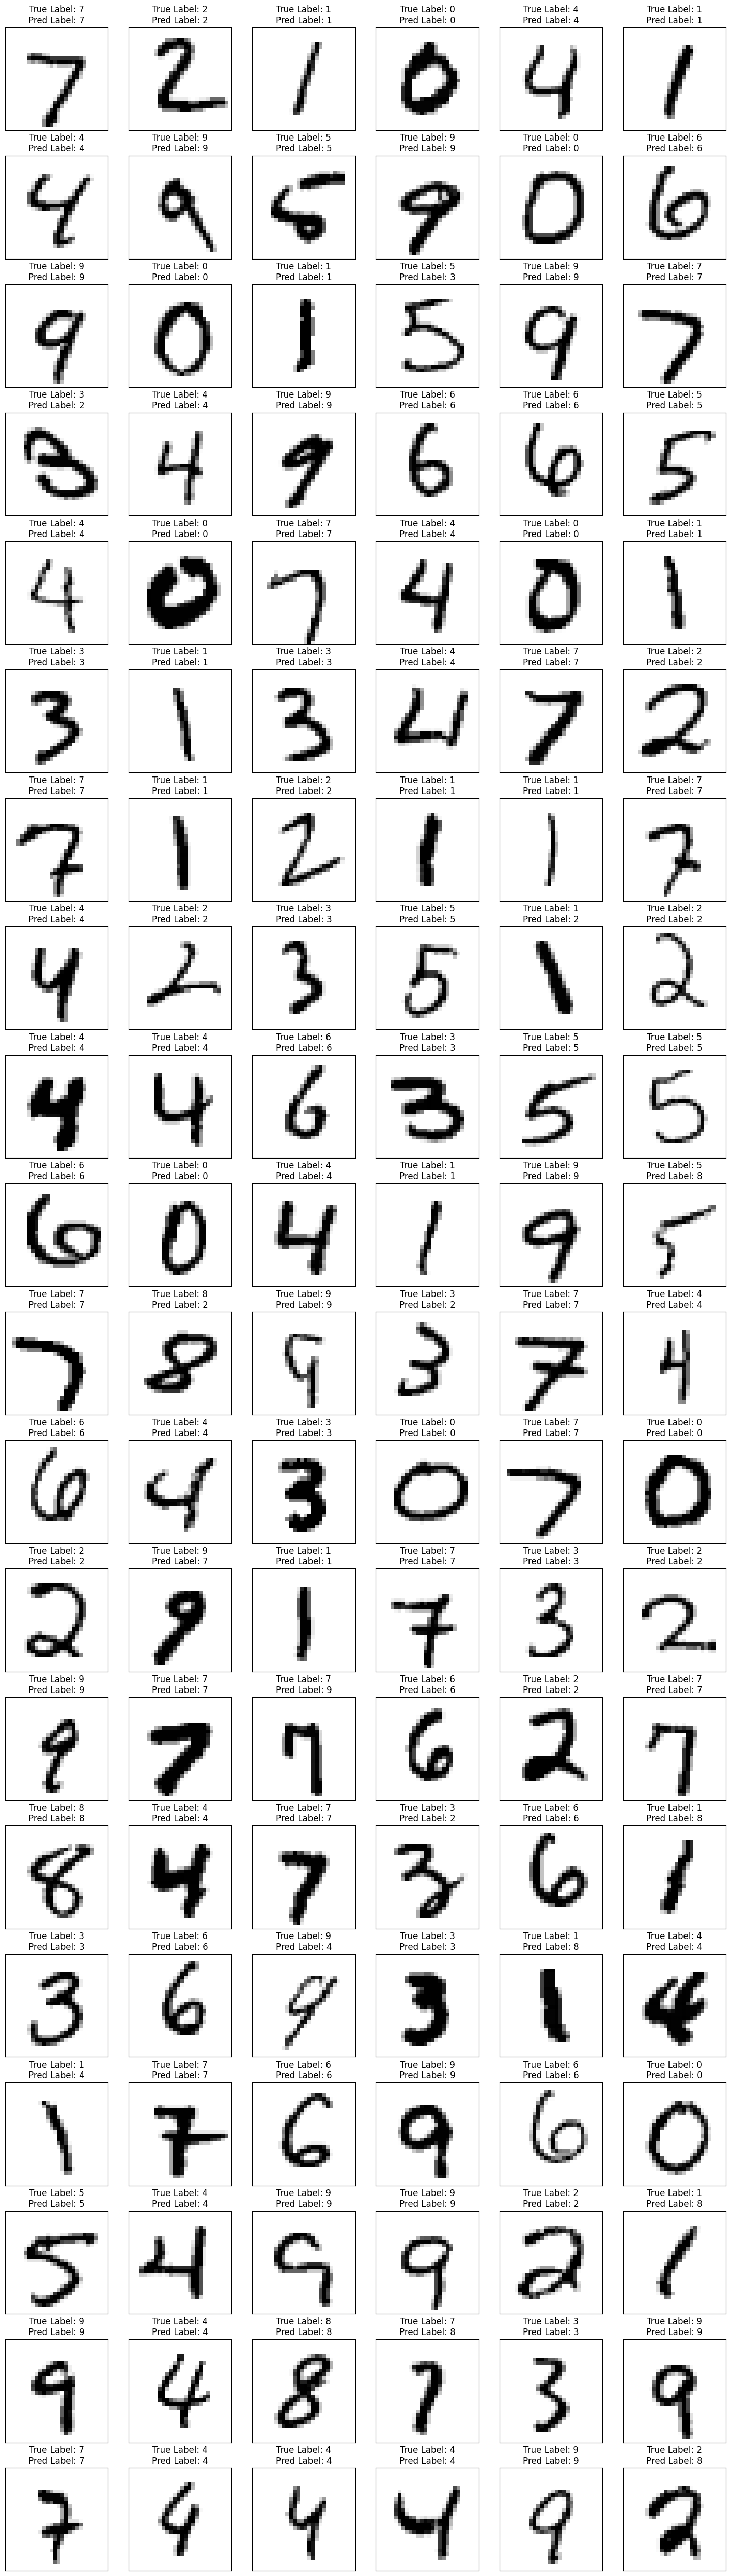

In [9]:
# Learn a single (general) Gaussian per class
def learnClassConditionalDist( X, y ):
    (labels, labelCounts) = np.unique( y, return_counts = True )
    C = labels.size
    (n, d) = X.shape
    muVals = np.zeros( (C, d) )
    SigmaVals = np.zeros( (C, d, d) )
    for c in range( C ):
        XThisLabel = X[y == c]
        # MLE for mean is simply the empirical mean (aka sample mean) of feature vectors of this class
        muVals[c] = np.mean( XThisLabel, axis = 0 )
        XCent = XThisLabel - muVals[c]
        # MLE for covariance matrix is simply the empirical/sample covariance matrix of this class
        SigmaVals[c] = 1/labelCounts[c]*(XCent.T).dot( XCent )
    return (C, list( zip( muVals, SigmaVals, np.arange( C ), labelCounts/n ) ))

# Stretch out the 28 x 28 image into a 784 dimensional vector
def flattenTensor( X ):
    n = X.shape[0]
    d = np.prod( X.shape[1:] )
    return X.reshape( n, d )

def predictClassScores( X, mu, Sigma, p, mask = [] ):
    # If no mask was provided, then we need to consider all coordinates of the feature vector
    if len(mask) == 0:
        mask = np.ones( (X.shape[1],), dtype=bool )
    
    XCent = X[:,mask] - mu[mask]
    # The covariance matrix will mostly be non-invertible in this case
    # This is because some pixels are always white in every image i.e. zero variance
    # The Moore-Penrose "pseudoinverse" is used in such situations
    SInv = lin.pinv( Sigma[mask,:][:,mask] )
    # numpy has a helpful routine that directly calculates the logdet of a matrix
    # More numerically stable in several situations -- no exploding outputs
    (sign, logdet) = lin.slogdet( Sigma[mask,:][:,mask] )
    # sign = 0 is the routines way of telling us that the determinant was zero
    # The determinant of a covariance matrix should always be non-negative
    if sign <= 0:
        SLogDet = 0
    else:
        SLogDet = logdet
    # This term gives us (ignoring additive constants) ln P[x | y, \theta]
    term1 = 0.5 * (-SLogDet - np.sum( np.multiply( np.dot(XCent, SInv), XCent), axis = 1 ))
    # This term gives us ln P[y | \theta]
    term2 = np.log( p )
    return term1 + term2

def predictGen( X, model, C, mask = [] ):
    classScores = np.zeros( (X.shape[0], C) )
    for mu, Sigma, c, p in model:
        classScores[:,c] = predictClassScores( X, mu, Sigma, p, mask )
    return np.argmax( classScores, axis = 1 )

((XTrain, yTrain), (XTest, yTest)) = mnist.load_data()

# Normalize data coordinates otherwise numbers in later calculations explode
# Also, flatten images for sake of convenience
imShape = XTrain.shape[1:]
XTrainFlat = flattenTensor( XTrain/256 )
XTestFlat = flattenTensor( XTest/256 )

(C, model) = learnClassConditionalDist( XTrainFlat, yTrain )
yPred = predictGen( XTestFlat, model, C )

print( "Prediction Accuracy: ", sum(yPred == yTest)/yTest.size )

numRows = 20
numCols = 6

fig13, axs13 = getFigList( numRows, numCols, sizey = 3.2 )
labels = ["True Label: %s\nPred Label: %s" % (yTest[i], yPred[i]) for i in range( numRows * numCols )]
showImagesNoAxes( axs13, XTestFlat[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

**Classification in the presence of missing features**: a very nice property of generative models is that they allow us to perform classification on test points even those test points have missing features. Generative models can also function even if training data has missing features but those algorithms are more involved since they require the use of latent variables and some version of the EM algorithm to be executed.

Below we use the generative mode we trained above, to classify test images for whom a whole bunch of pixels have been removed or _censored_. We see that classification accuracy drops as more and more pixels are wiped out which is expected. What is interesting is that if we wipe out all pixels (we can do this by setting X[:, :, :] = 0 in the method censorImages() below), we get a prediction accuracy of around 11%. The reason for this is two-fold.
1. We will see that when all pixels are wiped out, the method always predicts the label of the image as 1. Since 1s constitute around 11% of the dataset, this explains the 11% accuracy since the method is technically correct on those images.
1. The reason why the method predicts 1 as the default label for a totally blank image has to do with the fact that the the label 1 is among the most popular in the dataset and so the class has high prior probability. Moreover, images of the digit 1 contain the most blank/white space so even in terms of likelihood, the label 1 wins when the image is completely blank.
1. The above two factors imply that the label 1 wins for a blank image.

In the following, we remove around 21% of the central portion of the test images. This causes prediction accuracy to drop to 78.57. However, given their generative capabilities, generative models are not just able to classify test data points with missing features, they are able to _impute_ or fill-in those missing features with reasonable values as well. Examples of such reconstructions are given below. Note that the reconstructions are decent although a bit blurry. This is all the more impressive when we look at the censored images which, to the human eye, seem to convey little information about the true image since the central portions are crucial in the images and those are exactly the pixels that got censored. Also notice that some of the misclassification are reasonable e.g. misclassifying a 9 as a 7 etc.

Prediction Accuracy on Censored Images:  0.7857


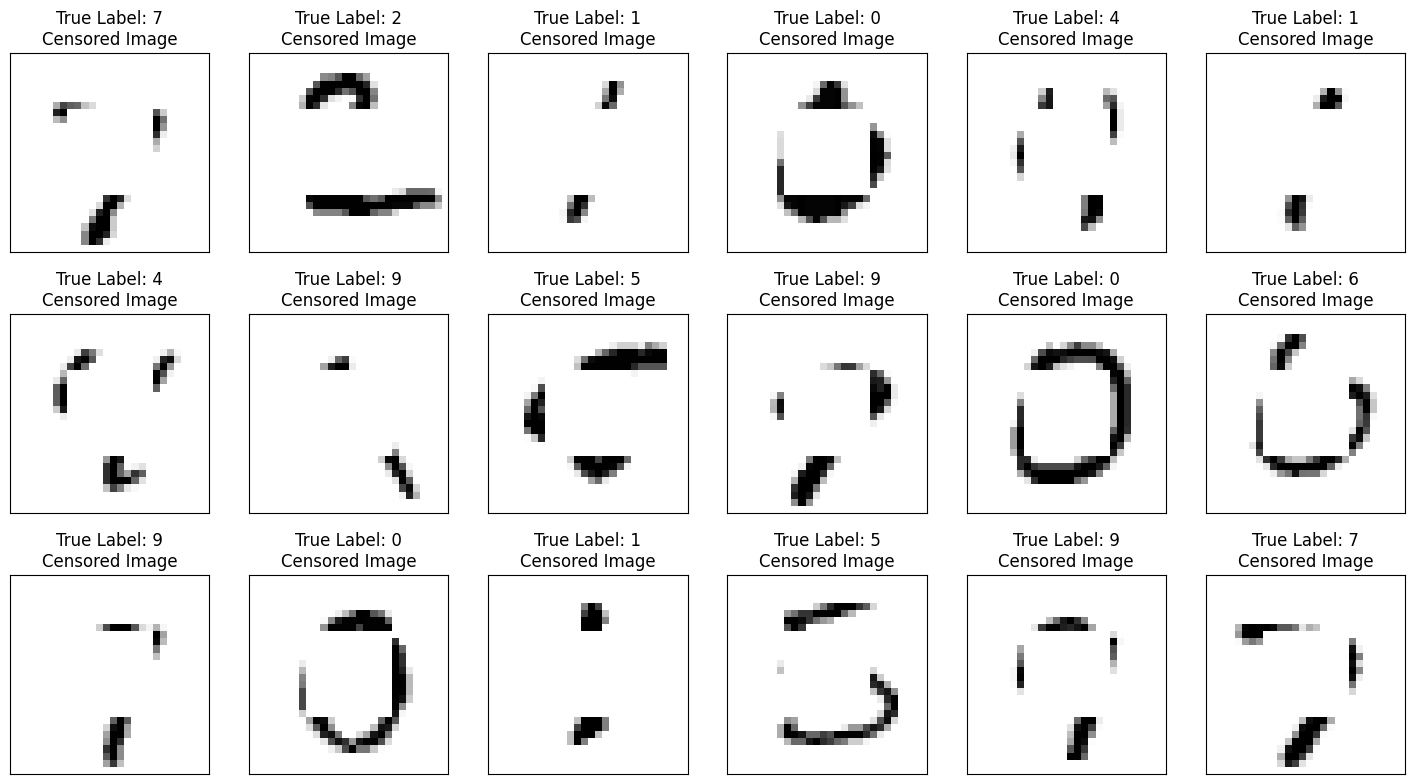

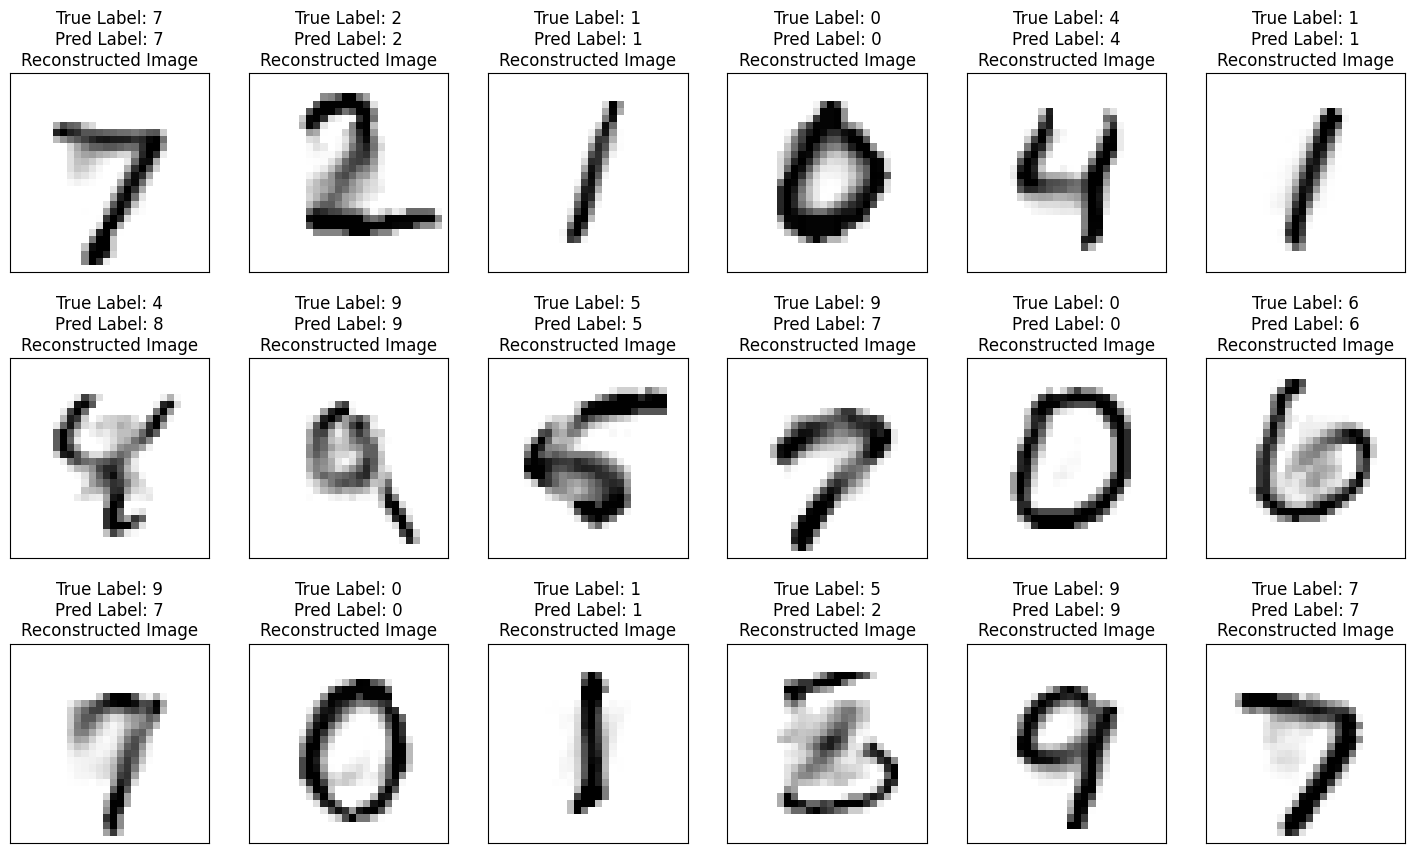

In [10]:
# You may try more aggressive censoring e.g. X[:, 5:20, 5:20] = 0 which wipes out around 28% of the pixels
# Accuracy will fall as we wipe out more and more pixels
def censorImages( X ):
    # Wipe out 21% of the pixels from the central part of the image
    X[:, 8:20, 8:20] = 0
    return X

# Make sure that reconstructed image does not have any negative-valued pixels
def truncatePixels( X, low = 0, high = 1 ):
    X[X < low] = low
    X[X > high] = high
    return X

# Reconstruct the image using the Gaussian conditionals
def reconstructImages( X, yPred, model, mask ):
    XRecon = np.zeros( X.shape )
    # Pixels observed are used as is in the reconstruction
    XRecon[:, mask] = X[:, mask]
    for i in range( X.shape[0] ):
        ( mu, Sigma, c, p ) = model[yPred[i]]
        recon = mu[~mask] + Sigma[~mask,:][:,mask].dot( lin.pinv( Sigma[mask,:][:,mask] ).dot( (XRecon[i,mask] - mu[mask]) ) )
        XRecon[i, ~mask] = recon
    return truncatePixels( XRecon )

XTestCensorFlat = flattenTensor( censorImages( XTest ) / 256 )
mask = flattenTensor( censorImages( np.ones( imShape )[np.newaxis, :] ) )[0] == 1

yPred = predictGen( XTestCensorFlat, model, C, mask )

print( "Prediction Accuracy on Censored Images: ", sum(yPred == yTest)/yTest.size )

numRows = 3
numCols = 6

XTestReconFlat = reconstructImages( XTestCensorFlat[:numRows*numCols], yPred[:numRows*numCols], model, mask )

fig14, axs14 = getFigList( numRows, numCols, sizey = 3.2 )
labels = ["True Label: %s\nCensored Image" % yTest[i] for i in range( numRows * numCols )]
showImagesNoAxes( axs14, XTestCensorFlat[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

fig15, axs15 = getFigList( numRows, numCols, sizey = 3.5 )
labels = ["True Label: %s\nPred Label: %s\nReconstructed Image" % (yTest[i], yPred[i]) for i in range( numRows * numCols )]
showImagesNoAxes( axs15, XTestReconFlat[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )